In [1235]:
max_batch_sizes = {
    "EleutherAI/gpt-neo-1.3B": 32,
    "EleutherAI/gpt-neo-2.7B": 16,
    "EleutherAI/gpt-j-6B": 8,
    "albert-xxlarge-v2": 32,
    "facebook/opt-6.7b": 16,
    "xlm-roberta-large": 32,
    # conservative:
    "gpt2": 64,
    "gpt2-large": 16,
    "gpt2-xl": 8,
    "llama7B": 1,
}

max_gpus = 9
default_batch_size = 128

get_batch_size = lambda x: max_batch_sizes.get(x, default_batch_size)

In [1236]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

import fastmodellib as fml
from fastmodellib.log_utils import load_logs_from_dir, agg_logs, get_experiment_duration
from fastmodellib.deploy import ModelDeployer, ModelTask, DeepSpeedTask, PythonTask
from fastmodellib.deploy import get_device_placement, make_param_grid

sb.set_theme(context="talk", style="ticks")
sb.set_palette("deep")

max_gpus = 9

deployer = ModelDeployer()
deployer.status()

pending 0
tasks 0
finished 0


In [1244]:
mask_models = ["distilbert-base-uncased", 
               "bert-base-uncased", "bert-large-uncased", "bert-base-multilingual-uncased",
               "distilroberta-base", 
               "roberta-base", "roberta-large", 
               "xlm-roberta-base", "xlm-roberta-large", 
               "albert-xxlarge-v2",
]
causal_models = ["gpt2", "gpt2-large", "gpt2-xl", "llama7B", "EleutherAI/gpt-neo-2.7B"]


# definitions

datasets = ["moral-stories", "contrastive-moral-stories", "tweet-eval", "swag"]
prompt_dir = "data/prompts/"

masked_train_notebook = "train_masked_classification.ipynb"
masked_prompt_notebook = "prompt_mask_lms.ipynb"

causal_train_notebook = "train_causal_classification.ipynb"
causal_prompt_notebook = "prompt_causal_lms.ipynb"

seq_class_train_notebook = "train_sequence_classification.ipynb"



# load prompts...
prompt_dir = "data/prompts/"
prompt_files = [x for x in os.listdir(prompt_dir) if x.startswith("prompt") and x.endswith(".jsonl")]

prompt_dfs = {}

for pf in prompt_files:
    d = pd.read_json(prompt_dir + pf, orient="records", lines=True)
    if len(d) < 1000: continue
    # 1: norm has positive moral judgment, 0 negative
    d["original_label"] = (d["action-moral-judgment"] > 0).astype("int32")

    prompt_dfs[pf.removesuffix(".jsonl")] = d

print(f"Loaded {len(prompt_dfs)} prompt tasks")


# load topic prompts:
topic_prompt_dir = "data/prompts/topics/"
topic_prompt_files = [x for x in os.listdir(topic_prompt_dir) if x.endswith(".jsonl")]

topic_prompt_dfs = {}

for pf in topic_prompt_files:
    d = pd.read_json(topic_prompt_dir + pf, orient="records", lines=True)
    # 1: norm has positive moral judgment, 0 negative
    d["original_label"] = (d["action-moral-judgment"] > 0).astype("int32")

    topic_prompt_dfs[pf.removesuffix(".jsonl")] = d

print(f"Loaded {len(topic_prompt_dfs)} topic prompt tasks")


# for plotting:

model_order = [
    'distilbert-base-uncased', 'bert-base-uncased', 'bert-large-uncased', 
    'distilroberta-base', 'roberta-base','roberta-large',
    'albert-xxlarge-v2',
    'bert-base-multilingual-uncased', 'xlm-roberta-base', 'xlm-roberta-large',
     'gpt2', 'gpt2-large', 'gpt2-xl','EleutherAI/gpt-neo-2.7B', 'llama7B'
]


model_display_names = {
    'distilbert-base-uncased': "distilbert",
    'bert-base-uncased': "bert-b.",
    'bert-large-uncased': "bert-l.",
    'bert-base-multilingual-uncased': "bert-b.-ml",
    'distilroberta-base': "distilroberta",
    'roberta-base': "roberta",
    'roberta-large': "roberta-l.",
    'xlm-roberta-base': "xlm-roberta",
    'xlm-roberta-large': "xlm-roberta-l.",
    'albert-xxlarge-v2': "albert-xxl",
    'gpt2': "gpt2",
    'gpt2-large': "gpt2-l.",
    'gpt2-xl': "gpt2-xl",
    'llama7B': "llama7B",
    'EleutherAI/gpt-neo-2.7B': "gpt-neo-2.7B"
}

model_sizes = pd.DataFrame.from_records([('distilbert-base-uncased', 66362880),
 ('distilroberta-base', 82118400),
 ('bert-base-uncased', 109482240),
 ('gpt2', 124439808),
 ('roberta-base', 124645632),
 ('bert-base-multilingual-uncased', 167356416),
 ('albert-xxlarge-v2', 222595584),
 ('xlm-roberta-base', 278043648),
 ('bert-large-uncased', 335141888),
 ('roberta-large', 355359744),
 ('xlm-roberta-large', 559890432),
 ('gpt2-large', 774030080),
 ('gpt2-xl', 1557611200),
 ('EleutherAI/gpt-neo-2.7B', 2651307520),
 ('llama7B', 6607343616)], columns=["model","size"])
model_sizes = model_sizes.set_index("model")

model_sizes["dataset_size"] = 0
a = pd.DataFrame(index=model_sizes.index, columns=["size"], dtype="int32")
a.loc["bert-base-uncased"] = 16
a.loc["bert-large-uncased"] = 16
a.loc["distilbert-base-uncased"] = 16
a.loc["albert-xxlarge-v2"] = 320
a.loc["roberta-base"] = 160
a.loc["roberta-large"] = 160
a.loc["distilroberta-base"] = 40
a.loc["gpt2"] = 40
a.loc["gpt2-large"] = 40
a.loc["gpt2-xl"] = 40
# at most 60gb based on the size of full wikipedia in 2019.
a.loc["bert-base-multilingual-uncased"] = 60
a.loc["xlm-roberta-base"] = 2500
a.loc["xlm-roberta-large"] = 2500
a.loc["EleutherAI/gpt-neo-2.7B"] = 800
a.loc["llama7B"] = 4500


model_sizes["dataset_size"] = a


def extract_runtime(x):
    return pd.to_timedelta(x, unit="s").item()

def parse_index_from_checkpoints(x):
    # x: path like "epochX_stepY/bsZ_lr_W"
    # or "epochX_stepY"
    def parse_left(left):
        epoch, step = left.split("_")
        epoch = int(epoch[5:])
        step = int(step[4:])
        return epoch, step
    def parse_right(right):
        batch_size, lr = right[2:].split("_lr_")
        batch_size = int(batch_size)
        lr = float(lr)
        return batch_size, lr
    if "/" in x:
        left, right = x.split("/")
        epoch, step = parse_left(left)
        batch_size, lr = parse_right(right)
        return {"epoch":epoch, "step":step, "lr":lr, "batch_size":batch_size}
    else:
        epoch, step = parse_left(x)
        return {"epoch":epoch, "step":step}     
    
# helper functions

def deploy_param_grid(pgrid, notebook, experiment_name, override_logdir=True, deepspeed=True, min_gpus=1):
    '''
    Deploys a parameter grid [(model, task, bs, lr), ..., ] on gpus using our standard setup
    Currently only works for finetuning pretrained models.
    '''
    for model_name, dataset, batch_size, lr in pgrid:
        logdir = f"data/models/{experiment_name}/{dataset}/{model_name}/bs{batch_size}_lr_{str(lr).replace('.','_')}/"
        max_bs = get_batch_size(model_name)
        device_bs, num_gpus, grad_acc = get_device_placement(batch_size, max_device_batch_size=max_bs, max_gpus=max_gpus, min_gpus=min_gpus)
        training_args = {
            "num_train_epochs": 4,
            "save_strategy": "epoch",
            "per_device_train_batch_size": device_bs,
            "per_device_eval_batch_size": device_bs,
            "gradient_accumulation_steps": grad_acc,
            "learning_rate": lr,
            "do_predict": True,
            "do_train":True,
            "do_eval":True,
            "load_best_model_at_end": True,
        }

        deployer.enqueue(notebook=notebook, model_name = model_name, logdir=logdir, from_checkpoint=None, dataset=dataset,
                         override_logdir=override_logdir, num_gpus=num_gpus, training_args=training_args, deepspeed=deepspeed)

        
def get_failed_runs(aggs, pgrid):
    '''
    Returns list of crashed and list of missing runs.
    Determined by results given by the aggregated_logs and the pgrid.
    Retuned lists are pgrids themselves!
    '''
    todos = set(pgrid)

    # get the runs that crashed, i.e. have some nan value
    nans = set(tuple(x) for x in aggs[aggs.isna().any(axis=1)][["model", "task","batch_size","lr"]].values.tolist())
    nans.intersection_update(todos)

    # get all runs that werent started
    fully_run = aggs[~aggs.isna()]
    done = set(tuple(x) for x in fully_run[["model", "task","batch_size","lr"]].values.tolist())
    missing = todos.difference(done)
    
    crashed = sorted(nans, key=lambda x: x[0])
    missing = sorted(missing, key=lambda x: x[0])
    return crashed, missing

def parse_params_from_path_with_model(x):
    # path like: original_ms/albert-xxlarge-v2/bs64_lr_1e-05
    # or /albert-xxlarge-v2
    
    if "/" in x:
        task, r = x.split("/", 1)
        model, r = r.rsplit("/", 1)
        bs, lr = r[2:].split("_lr_")
        bs = int(bs)
        lr = float(lr.replace("_","."))
    else:
        task = "pretrained"
        model = x
        bs = np.nan
        lr = np.nan
    return {"task":task, "model":model, "batch_size":bs, "lr":lr}

def load_classification_task_logs(path):
    '''
    Loads all logs from a classification task.
    It assumes that all logs are under '<path>/<model-name>/<run-name>/'
    The different runs are aggregated per task + model.
    First, the best epoch (in terms of accuracy on dev set) is determined for each single run
    Next, the best run per model is determined
    
    returns:
    DataFrame with nested index: (<task-name>,<model-name>)
    '''
    logs = load_logs_from_dir(path)
    cols = {f"test/{x}_loss":"min" for x in ["train", "dev", "test"]}
    cols.update({f"test/{x}_accuracy":"min" for x in ["train", "dev", "test"]})
    aggs = agg_logs(logs, columns=cols)
    #aggs = aggs.sort_values("test/test_accuracy", ascending=False)
    best_epoch = agg_logs(logs, {"eval/accuracy":"argmax"}) + 1
    best_epoch.columns = ["best_epoch"]
    aggs = aggs.join(best_epoch)
    d = pd.DataFrame.from_records(aggs.index.map(parse_params_from_path_with_model), index=aggs.index)
    aggs = aggs.join(d)
    aggs.columns = [x.removeprefix("test/") for x in aggs.columns]
    groups = aggs.groupby(["task","model"])
    best_runs = groups.agg({"dev_accuracy":np.argmax})
    best = groups.apply(lambda x: x.iloc[best_runs.loc[x.name]["dev_accuracy"]])
    #best = best.drop(["task", "model"],axis=1)
    return aggs, best

def load_prompt_task_logs(path):
    # similar to load_cload_classification_task_logs!
    import llama_prompt_gen
    logs = load_logs_from_dir(path)

    aggregations = {f"train/{x}_accuracy": "max" for x in llama_prompt_gen.templates.keys()}
    aggregations = {k:v for k,v in aggregations.items() if k in logs.columns}
    aggs = agg_logs(logs, aggregations)

    d = pd.DataFrame.from_records(aggs.index.map(parse_params_from_path_with_model), index=aggs.index)
    aggs = aggs.join(d)
    aggs.columns = [x.removeprefix("train/").removesuffix("_accuracy") for x in aggs.columns]
    aggs = aggs.set_index(pd.MultiIndex.from_frame(aggs[["task","model"]]))
    return aggs


Loaded 9 prompt tasks
Loaded 63 topic prompt tasks


In [1238]:
import glob
def load_prompt_results(results_dir="data/models/prompts/"):
    result_files = glob.glob(results_dir+"**/prompt_results.jsonl", recursive=True)

    dfs = [pd.read_json(r, orient="records", lines=True, dtype="float") for r in result_files]

    index = pd.MultiIndex.from_product([result_files, dfs[0].index])

    a = pd.DataFrame(index=index, columns=dfs[0].columns, dtype="float32")

    for r, df in zip(result_files, dfs):
        a.loc[r, df.columns] = df.values

    def t(x):
        y = x
        x = x.removeprefix(results_dir).removesuffix("/prompt_results.jsonl")
        try:

            if x.startswith("pretrained/"):
                task, model = x.split("/", 1)

            else:
                _, task, x = x.split("/",2)
                model, _ = x.rsplit("/",1)
        except:
            print(y)
        return task, model

    k = a.index.to_series().map(lambda x: t(x[0]) + (x[1],))
    pindex = pd.MultiIndex.from_tuples(k, names=["task","model","y_pred"])

    a = a.set_index(pindex)
    return a.sort_index()

In [1269]:
results_dir = "data/models/prompts_long/"
x = "data/models/prompts_long/all/tweet-eval/roberta-base/checkpoint-4794/prompt_results.jsonl"
y = x
x = x.removeprefix(results_dir).removesuffix("/prompt_results.jsonl")
print(x)
if x.startswith("pretrained/"):
    task, model = x.split("/", 1)

else:
    _, task, x = x.split("/",2)
    model, _ = x.rsplit("/",1)


all/tweet-eval/roberta-base/checkpoint-4794


# Classification via Language Modeling
***


Tasks:
* Decide on models
    * Masked: "distilbert-base-uncased", 
               "bert-base-uncased", "bert-large-uncased", "bert-base-multilingual-uncased",
               "distilroberta-base", 
               "roberta-base", "roberta-large", 
               "xlm-roberta-base", "xlm-roberta-large", 
               "albert-xxlarge-v2"
    * Causal: GPT2
* Decide on downstream benchmarks
    * Morally charged: MS, CMS
    * Neutral: boolQ
* Run adaptive finetuning for masked LMs
* Run adaptive finetuning for causal LMs
* Run standard seq. class. finetuning for masked & causal LMs
* Show differences between adaptive finetuning and standard seq. class for all models
* Develop prompts to test for moral biases on masked and causal LMs
* Test prompts on pre-trained masked and causal models
* Test prompts on adaptively-finetuned masked and causal models
    * Visualize results

## Standard sequence classification
***

### Run configuration

In [7]:
# Todo: run swag on all models
pgrid = make_param_grid(mask_models + causal_models, datasets, [32, 64], [1e-5, 5e-5, 1e-4])

## Find OOM runs and reschedule
***

In [181]:

aggs, best = load_classification_task_logs("data/models/masked_classification/")

#failed = aggs[aggs.index.map(lambda x: "neo" in x)]
failed = aggs[aggs.isna().any(axis=1)]
ooms = failed[~failed["best_epoch"].isna()]
ooms

,train_loss,dev_loss,test_loss,train_accuracy,dev_accuracy,test_accuracy,best_epoch,task,model,batch_size,lr


In [ ]:
for i, row in ooms.iterrows():
    logdir = f"data/models/masked_classification/{row.task}/{row.model}/bs{row.batch_size}_lr_{str(row.lr).replace('.','_')}/"
    max_bs = get_batch_size(model_name)
    device_bs, num_gpus, grad_acc = get_device_placement(row.batch_size, max_device_batch_size=max_bs, max_gpus=1, min_gpus=1)
    training_args = {
        "per_device_train_batch_size": device_bs,
        "per_device_eval_batch_size": device_bs,
        "gradient_accumulation_steps": grad_acc,
        "do_predict": True,
        "do_train":False,
        "do_eval":True,
    }
    ckpts = glob.glob(logdir + "checkpoint-*")

    print(logdir, len(ckpts), int(row.best_epoch))
    if len(ckpts) > 1:
        raise ValueError(f"There are more than one ckpts in dir: {logdir}")
    deployer.enqueue(notebook=causal_train_notebook, model_name = row.model, logdir=logdir, from_checkpoint=ckpts[0], 
                     dataset=row.task, override_logdir=False, num_gpus=num_gpus, training_args=training_args, backend="python")

### Results


#### For appendix

In [1198]:
aggs, best = load_classification_task_logs("data/models/sequence_classification/")
m = model_order.remove("llama7B")
best = best.loc[pd.MultiIndex.from_product([best.index.get_level_values(0).unique(), model_order], names=["task","model"])]
model_order.append("llama7B")

formatted = best.copy()
formatted["lr"] = formatted["lr"].apply(lambda x: f"{x:.0e}".replace("0",""))
formatted = formatted.set_index(formatted.index.map(lambda x: (x[0], x[1].removesuffix("-uncased"))))
formatted["model"] = formatted["model"].apply(lambda x: x.removesuffix("-uncased"))

#formatted = formatted.loc["moral-stories"]
formatted = formatted.style


loss_cols = [x for x in formatted.columns if "loss" in x]
formatters = {x:lambda c: f"{c:.4f}" for x in loss_cols}

acc_cols = [x for x in formatted.columns if "accuracy" in x]
formatters.update({x:lambda c: "{:,.1f}".format(100*c) for x in acc_cols})

formatters.update({"best_epoch":lambda x: str(int(x))})


formatted = formatted.format(formatters)

formatted = formatted.hide(["task","train_loss","train_accuracy","model"], axis=1)
#formatted.set_caption("Sequence classification results")

#print(formatted.to_latex())

## Masked Language Modeling
***

### Run configuration

In [8]:
pgrid = make_param_grid(mask_models, datasets, [32, 64], [1e-5, 5e-5, 1e-4])

#deploy_param_grid(pgrid, masked_train_notebook, "masked_classification")

### Results

#### For appendix

In [1200]:
aggs, best = load_classification_task_logs("data/models/masked_classification/")
# sort models
best = best.loc[pd.MultiIndex.from_product([best.index.get_level_values(0).unique(), model_order], names=["task","model"])]

formatted = best.copy()
formatted["lr"] = formatted["lr"].apply(lambda x: f"{x:.0e}".replace("0",""))
formatted = formatted.set_index(formatted.index.map(lambda x: (x[0], x[1].removesuffix("-uncased"))))
formatted["model"] = formatted["model"].apply(lambda x: x.removesuffix("-uncased"))

#formatted = formatted.loc["moral-stories"]
formatted = formatted.style

loss_cols = [x for x in formatted.columns if "loss" in x]
formatters = {x:lambda c: f"{c:.4f}" for x in loss_cols}

acc_cols = [x for x in formatted.columns if "accuracy" in x]
formatters.update({x:lambda c: "{:,.1f}".format(100*c) for x in acc_cols})

formatters.update({"best_epoch":lambda x: str(int(x))})

formatted = formatted.format(formatters)

formatted = formatted.hide(["task","train_loss","train_accuracy","model"], axis=1)
#formatted.set_caption("Sequence classification results")

#print(formatted.to_latex())

### Result comparison
***

In [1425]:
aggs_masked, best_masked = load_classification_task_logs("data/models/masked_classification/")
aggs_seq, best_seq = load_classification_task_logs("data/models/sequence_classification/")

#### For paper

In [1427]:
# sequence class. perf

best_seq
d = pd.DataFrame(index=best_masked.index.get_level_values(1).unique(), columns=pd.MultiIndex.from_product([datasets, ["seq_acc", "diff", "pt_acc"]]))
for ds in datasets:
    d[ds, "seq_acc",] = best_seq.loc[ds]["test_accuracy"]
    d[ds, "pt_acc",] = best_masked.loc[ds]["test_accuracy"]
    d[ds, "diff",] = best_masked.loc[ds]["test_accuracy"] - best_seq.loc[ds]["test_accuracy"]

# apply order:
d = d.loc[model_order]
# get mean
mean = d.mean(axis=0)
mean.name = "mean"
d = pd.concat([d, mean.to_frame().T])
d = d.dropna()

idx = pd.IndexSlice
formatted = d.loc[:,idx[datasets,["pt_acc","diff"]]].style
acc_cols = [x for x in formatted.columns if "accuracy" in x]
formatters.update({x:lambda c: "{:,.1f}".format(100*c) for x in acc_cols})

formatted = formatted.format(lambda c: "{:,.1f}".format(100*c))

#print(formatted.to_latex())

In [1429]:
d.corr("spearman")

moral-stories                      \
                                        seq_acc      diff    pt_acc   
moral-stories             seq_acc      1.000000  0.039321  0.921429   
                          diff         0.039321  1.000000  0.355675   
                          pt_acc       0.921429  0.355675  1.000000   
contrastive-moral-stories seq_acc      0.970510  0.073345  0.895443   
                          diff         0.014286  0.221627  0.189286   
                          pt_acc       0.975000  0.160858  0.957143   
tweet-eval                seq_acc      0.396429  0.130474  0.378571   
                          diff         0.560714  0.210903  0.560714   
                          pt_acc       0.782143  0.275246  0.753571   
swag                      seq_acc      0.885714  0.051832  0.850000   
                          diff         0.696429  0.141198  0.739286   
                          pt_acc       0.939286  0.021448  0.903571   

                                  contrastive-moral-stories            \
                                                    seq_acc      diff   
moral-stories             seq_acc                  0.970510  0.014286   
                          diff                     0.073345  0.221627   
                          pt_acc                   0.895443  0.189286   
contrastive-moral-stories seq_acc                  1.000000 -0.114388   
                          diff                    -0.114388  1.000000   
                          pt_acc                   0.949062  0.107143   
tweet-eval                seq_acc                  0.405720 -0.203571   
                          diff                     0.580876 -0.053571   
                          pt_acc                   0.829312 -0.192857   
swag                      seq_acc                  0.870420 -0.064286   
                          diff                     0.625559  0.346429   
                          pt_acc                   0.899017 -0.014286   

                                            tweet-eval                      \
                                     pt_acc    seq_acc      diff    pt_acc   
moral-stories             seq_acc  0.975000   0.396429  0.560714  0.782143   
                          diff     0.160858   0.130474  0.210903  0.275246   
                          pt_acc   0.957143   0.378571  0.560714  0.753571   
contrastive-moral-stories seq_acc  0.949062   0.405720  0.580876  0.829312   
                          diff     0.107143  -0.203571 -0.053571 -0.192857   
                          pt_acc   1.000000   0.371429  0.578571  0.778571   
tweet-eval                seq_acc  0.371429   1.000000 -0.267857  0.335714   
                          diff     0.578571  -0.267857  1.000000  0.789286   
                          pt_acc   0.778571   0.335714  0.789286  1.000000   
swag                      seq_acc  0.871429   0.542857  0.464286  0.746429   
                          diff     0.678571  -0.014286  0.442857  0.446429   
                          pt_acc   0.917857   0.478571  0.489286  0.732143   

                                       swag                      
                                    seq_acc      diff    pt_acc  
moral-stories             seq_acc  0.885714  0.696429  0.939286  
                          diff     0.051832  0.141198  0.021448  
                          pt_acc   0.850000  0.739286  0.903571  
contrastive-moral-stories seq_acc  0.870420  0.625559  0.899017  
                          diff    -0.064286  0.346429 -0.014286  
                          pt_acc   0.871429  0.678571  0.917857  
tweet-eval                seq_acc  0.542857 -0.014286  0.478571  
                          diff     0.464286  0.442857  0.489286  
                          pt_acc   0.746429  0.446429  0.732143  
swag                      seq_acc  1.000000  0.417857  0.967857  
                          diff     0.417857  1.000000  0.603571  
                          pt_acc   0.967857  0.603571  1.000000

#### For appendix

Detailed results of hyper parameter search

## Causal Language Modeling
***

In [ ]:
# try llama?
# re run ms + cms on bs 4

### Run configuration

In [305]:
pgrid = make_param_grid(causal_models, datasets, [32, 64], [1e-5, 5e-5, 1e-4])

#deploy_param_grid(pgrid, causal_train_notebook, "masked_classification")

### Llama configuration

In [ ]:
pgrid = make_param_grid(['EleutherAI/gpt-neo-2.7B'], datasets, [32, 64], [1e-5, 5e-5, 1e-4])
deploy_param_grid(pgrid, causal_train_notebook, "masked_classification", min_gpus=2)

### Results


In [306]:
aggs, best = load_classification_task_logs("data/models/masked_classification/")

## Masked prompts
***


### Pre-trained
***

In [ ]:
for model_name in mask_models:
    logdir = f"data/models/prompts/pretrained/{model_name}/"
    batch_size = get_batch_size(model_name)
    deployer.enqueue(notebook=masked_prompt_notebook, model_name = model_name, logdir=logdir, prompt_dir=prompt_dir,
                     from_checkpoint=None, override_logdir=True, num_gpus=1, batch_size=batch_size)

### After downstream task
***

In [ ]:
# get all the best performing model configurations
aggs_masked, best_masked = load_classification_task_logs("data/models/masked_classification/")

2023-06-12 00:54:02.672683: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
for k, row in best_masked.iterrows():
    if row.model not in mask_models: continue
    rel_path = f"/masked_classification/{row.task}/{row.model}/bs{row.batch_size}_lr_{str(float(row.lr)).replace('.','_')}/"
    from_checkpoint = "data/models" + rel_path
    logdir = "data/models/prompts" + rel_path

    batch_size = get_batch_size(row.model)
    deployer.enqueue(notebook=masked_prompt_notebook, model_name = row.model, logdir=logdir, prompt_dir=prompt_dir,
                     from_checkpoint=from_checkpoint, override_logdir=True, num_gpus=1, batch_size=batch_size, intersect_vocabs=False)

In [ ]:
deployer.stop_all()

cancelled, shutting down
python terminated


## Causal Prompts
***

### Pretrained
***

In [ ]:
for model_name in ['EleutherAI/gpt-neo-2.7B']:
    logdir = f"data/models/prompts/pretrained/{model_name}/"
    batch_size = get_batch_size(model_name)
    # for some weird reason its very cheap to increase bs during inference..
    if "llama" in model_name:
        batch_size = 8
    deployer.enqueue(notebook=causal_prompt_notebook, model_name = model_name, logdir=logdir, prompt_dir=prompt_dir,
                     from_checkpoint=None, override_logdir=True, num_gpus=1, batch_size=batch_size)

### After downstream task
***

In [173]:
# get all the best performing model configurations
aggs_masked, best_masked = load_classification_task_logs("data/models/masked_classification")

In [ ]:
for k, row in best_masked.iterrows():
    if row.model not in causal_models: continue
    if row.model != 'EleutherAI/gpt-neo-2.7B': continue
    rel_path = f"/masked_classification/{row.task}/{row.model}/bs{row.batch_size}_lr_{str(float(row.lr)).replace('.','_')}/"
    from_checkpoint = "data/models" + rel_path
    logdir = "data/models/prompts" + rel_path

    batch_size = get_batch_size(row.model)

    if "llama" in model_name:
        batch_size = 8

    deployer.enqueue(notebook=causal_prompt_notebook, model_name = row.model, logdir=logdir, prompt_dir=prompt_dir,
                     from_checkpoint=from_checkpoint, override_logdir=True, num_gpus=1, batch_size=batch_size)

## Topic Prompts
***

### Deployment
***

In [ ]:
# pretrained models
for model_name in causal_models + mask_models:
    logdir = f"data/models/prompts_topic/pretrained/{model_name}/"
    batch_size = get_batch_size(model_name)

    if "llama" in model_name:
        batch_size = 8

    deployer.enqueue(notebook=causal_prompt_notebook if model_name in causal_models else masked_prompt_notebook, 
                     model_name = model_name, logdir=logdir, prompt_dir="data/prompts/topics/",
                     override_logdir=True, num_gpus=1, batch_size=batch_size)

In [ ]:
# After downstream tasks
for k, row in best_masked.iterrows():
    #if row.model not in mask_models: continue
    #if row.task == "tweet-eval": continue
    rel_path = f"/masked_classification/{row.task}/{row.model}/bs{row.batch_size}_lr_{str(float(row.lr)).replace('.','_')}/"
    from_checkpoint = "data/models" + rel_path
    logdir = "data/models/prompts_topic/" + rel_path

    batch_size = get_batch_size(row.model)

    if "llama" in model_name:
        batch_size = 8

    deployer.enqueue(notebook=causal_prompt_notebook if row.model in causal_models else masked_prompt_notebook, 
                     model_name = row.model, logdir=logdir, prompt_dir="data/prompts/topics/",
                     from_checkpoint=from_checkpoint, override_logdir=True, num_gpus=1, batch_size=batch_size)

### Eval
***

In [1402]:
def mean_topic_acc(g):
    topic_prompt_results = {}
    for n, c in g.iteritems():
        c = c.dropna().astype("int32").reset_index(drop=True)
        if len(c) == 0:
            topic_prompt_results[n] = np.nan
        else:
            topic_prompt_results[n] = (topic_prompt_dfs[n]["original_label"] == c).mean(skipna=True)

    topic_prompt_results = pd.DataFrame.from_records(topic_prompt_results, index=["Accuracy"])
    topic_prompt_results.columns = topic_prompt_results.columns.map(lambda x: tuple(x.split("_",1)))
    mean_per_topic = topic_prompt_results.groupby(axis=1, level=0).mean()
    return mean_per_topic

a = load_prompt_results("data/models/prompts_topic/")

In [1396]:
groups = a.groupby(["task","model"])
topic_means = groups.apply(mean_topic_acc).droplevel(2)
topic_means.columns = ["anti\nbullying","fidelity","anti\nlgbtq-phobia","anti\nracism","respecting\nothers", "anti\nsexism", "anti\nswearing"]

In [1424]:
'''
ge = groups.apply(lambda x: (x.mean(axis=1)>0.5).to_frame())

ge.columns = ["yo"]
ge.groupby(["task","model"]).apply(mean_topic_acc)
'''

'\nge = groups.apply(lambda x: (x.mean(axis=1)>0.5).to_frame())\n\nge.columns = ["yo"]\nge.groupby(["task","model"]).apply(mean_topic_acc)\n'

In [1397]:
diffs = topic_means.loc["tweet-eval"] - topic_means.loc["pretrained"]
abs_diffs = diffs.abs().sum(axis=1).to_frame()
abs_diffs["size"] = model_sizes["size"]
abs_diffs["dataset_size"] = model_sizes["dataset_size"]
abs_diffs["ratio"] = abs_diffs["size"] / abs_diffs["dataset_size"]

In [1398]:
m = topic_means.abs().groupby("task").mean()

(m.loc["tweet-eval"] - m.loc["pretrained"]).to_frame().T * 100

,anti\nbullying,fidelity,anti\nlgbtq-phobia,anti\nracism,respecting\nothers,anti\nsexism,anti\nswearing
0,-2.131888,-3.357339,-2.689211,-3.851852,-2.460766,-4.341564,-4.886212


In [1399]:
abs_diffs.corr("spearman")

,0,size,dataset_size,ratio
0,1.000000,0.000000,0.072471,-0.007143
size,0.000000,1.000000,0.556218,0.057143
dataset_size,0.072471,0.556218,1.000000,-0.770008
ratio,-0.007143,0.057143,-0.770008,1.000000


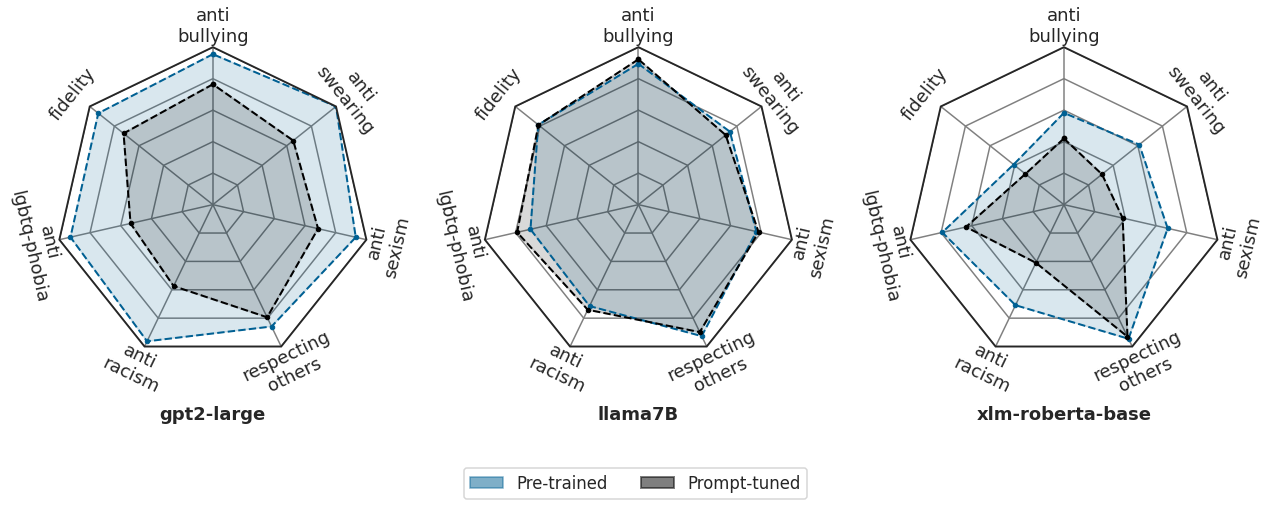

In [1400]:
from radar_plot import radar_factory
import seaborn as sb
import matplotlib.pyplot as plt

plots = [
    ("tweet-eval","gpt2-large"),
    ("tweet-eval","llama7B"),
#    ("tweet-eval","bert-base-uncased"),
    ("tweet-eval","xlm-roberta-base"),
    
]

sb.set_theme(context="talk", style="ticks")
sb.set_palette("Set2")

N = 7
theta = radar_factory(N, frame='polygon')

fig, axes = plt.subplots(figsize=(18, 12), nrows=1, ncols=len(plots), subplot_kw=dict(projection='radar'))


for ax, (task,model) in zip(axes, plots):
    pt = topic_means.loc["pretrained",model]
    tw = topic_means.loc[task,model]

    ax.plot(theta, pt, "--.", alpha=1, label="_nolegend_", color="#006093", lw=2)
    h1 = ax.fill(theta, pt, alpha=0.15, label="Pre-trained", color="#006093")

    ax.plot(theta, tw, "--.", alpha=1, label="_nolegend_", color="black", lw=2)
    h2 = ax.fill(theta, tw, alpha=0.15, label="Prompt-tuned", color="black", lw=2, facecolor="black")

    ax.set_rgrids([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[], angle=25, fontweight="bold")
    labels = topic_means.columns
    ax.set_thetagrids(np.degrees(theta), labels)

    labels = []

    for label, angle in zip(ax.get_xticklabels(), np.degrees(theta)):
        if 90 < angle < 270:
            angle -= 180
        x,y = label.get_position()
        lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va())
        lab.set_rotation(angle)
        labels.append(lab)

    ax.set_xticklabels([])

    ax.tick_params(pad=5, grid_color="grey")
    ax.set_ylim(0,1)
    dn = model.removesuffix("-uncased")
    ax.set_title(dn, y=-0.2, size="medium", fontweight="bold")


# add legend relative to top-left plot
leg = plt.figlegend(handles=h1+h2, loc="lower center", bbox_to_anchor=(0.5,0.15), markerscale=5, ncol=2)
l = leg.legendHandles
l[0].set_alpha(0.5)
l[1].set_alpha(0.5)

#fig.text(0.5, 0.78, "Alignment with norms grouped by topic", horizontalalignment='center', color='black', weight='bold', size='medium')

plt.tight_layout()
plt.savefig("yo.png", dpi=300, bbox_inches='tight')
plt.show()

## More epochs
***



In [ ]:
# train roberta for 20 epochs on tweet eval


model_name = "roberta-base"
dataset = "contrastive-moral-stories"
batch_size = 64
lr = 5e-5


logdir = f"data/models/long_runs/{model_name}/{dataset}/{model_name}/bs{batch_size}_lr_{str(lr).replace('.','_')}/"
max_bs = get_batch_size(model_name)
device_bs, num_gpus, grad_acc = get_device_placement(batch_size, max_device_batch_size=max_bs, max_gpus=9)
training_args = {
    "num_train_epochs": 20,
    "save_strategy": "epoch",
    "per_device_train_batch_size": device_bs,
    "per_device_eval_batch_size": device_bs,
    "gradient_accumulation_steps": grad_acc,
    "learning_rate": lr,
    "do_predict": True,
    "do_train":True,
    "do_eval":True,
    "load_best_model_at_end": False,
    "save_total_limit": None,

    
}

deployer.enqueue(notebook=masked_train_notebook, model_name = model_name, logdir=logdir, from_checkpoint=None, dataset=dataset,
                 override_logdir=True, num_gpus=num_gpus, training_args=training_args, deepspeed=True)


In [ ]:
model_dir = "data/models/long_runs/roberta-base/contrastive-moral-stories/roberta-base/bs64_lr_5e-05/"
ckpts = glob.glob(model_dir + "checkpoint*/")

for ckpt in ckpts:

    logdir = f"data/models/prompts_long/all/{dataset}/{model_name}/{ckpt.split('/')[-2]}/"
    deployer.enqueue(notebook=masked_prompt_notebook, model_name = model_name, logdir=logdir, prompt_dir=prompt_dir,
                     from_checkpoint=ckpt, override_logdir=True, num_gpus=1, batch_size=128)

    logdir_topic = f"data/models/prompts_long/topic/{dataset}/{model_name}/{ckpt.split('/')[-2]}/"
    deployer.enqueue(notebook=masked_prompt_notebook, model_name = model_name, logdir=logdir_topic, prompt_dir=topic_prompt_dir,
                     from_checkpoint=ckpt, override_logdir=True, num_gpus=1, batch_size=128)
    

In [1323]:
def load_long_prompt_results(results_dir = "data/models/prompts_long/all/"):
    result_files = glob.glob(results_dir+"**/prompt_results.jsonl", recursive=True)

    dfs = [pd.read_json(r, orient="records", lines=True, dtype="float") for r in result_files]

    index = pd.MultiIndex.from_product([result_files, dfs[0].index])

    a = pd.DataFrame(index=index, columns=dfs[0].columns, dtype="float32")

    for r, df in zip(result_files, dfs):
        try:
            a.loc[r, df.columns] = df.values
        except:
            print("YO")
            break

    def t(x):
        y = x
        x = x.removeprefix(results_dir).removesuffix("/prompt_results.jsonl")
        try:

                task, model, ckpt = x.split("/")
        except:
            print(y)
        return task, model, ckpt

    k = a.index.to_series().map(lambda x: t(x[0]) + (x[1],))
    pindex = pd.MultiIndex.from_tuples(k, names=["task","model","ckpt","y_pred"])
    a = a.set_index(pindex)
    return a

In [1324]:
long_all = load_long_prompt_results("data/models/prompts_long/all/")
long_topic = load_long_prompt_results("data/models/prompts_long/topic/")

In [1329]:
# compute balanced accuracy per task/model/prompt
from sklearn.metrics import balanced_accuracy_score

y_true = prompt_dfs["prompt_reverse"]["original_label"]
baccs = long_all.groupby(["task","model","ckpt"]).apply(lambda g: g.apply(lambda x: np.nan if x.isna().any() else balanced_accuracy_score(y_true, x)))

In [1335]:
task = "contrastive-moral-stories"
b = baccs.loc[task]
bacc_statistics = pd.DataFrame(index=b.index)

g = b.groupby(["model","ckpt"])

bacc_statistics["mean"] = g.apply(lambda x: x.mean(axis=1).to_frame())
bacc_statistics["min"] = g.apply(lambda x: x.min(axis=1).to_frame())
bacc_statistics["max"] = g.apply(lambda x: x.max(axis=1).to_frame())
bacc_statistics["std"] = g.apply(lambda x: x.std(axis=1).to_frame())

bacc_statistics.columns = pd.MultiIndex.from_product([["ms_bacc"], bacc_statistics.columns])
bacc_statistics = bacc_statistics.sort_index(level=1, key=lambda y: [int(x.split("-")[1]) for x in y])

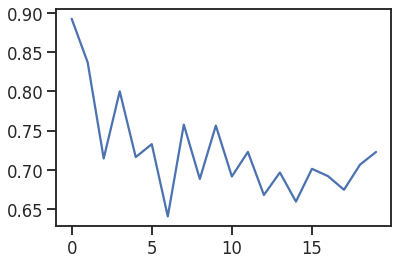

In [1342]:
plt.plot(bacc_statistics["ms_bacc","mean"].values)

plt.show()

## Prompting evaluation

In [1352]:
pr = load_prompt_results()

### Ensemble
***

In [1353]:
# Two strategies:
# Majority Vote
ensemble = pr.groupby(["task","model"]).apply(lambda x: (x.mean(axis=1)>0.5).to_frame())

In [1393]:
y_true = prompt_dfs["prompt_reverse"]["original_label"]
ensemble_baccs = ensemble.groupby(["task","model"]).apply(lambda g: g.apply(lambda x: np.nan if x.isna().any() else balanced_accuracy_score(y_true, x)))
ensemble_baccs = ensemble_baccs.loc[pd.MultiIndex.from_product([ensemble_baccs.index.get_level_values(0).unique(), model_order], names=["task","model"])]


In [1394]:
ensemble_baccs.groupby("task").mean() * 100

,0
task,
contrastive-moral-stories,67.708559
moral-stories,82.338635
pretrained,81.411321
swag,75.048003
tweet-eval,77.903074


In [1364]:
# compute balanced accuracy per task/model/prompt
from sklearn.metrics import balanced_accuracy_score

y_true = prompt_dfs["prompt_reverse"]["original_label"]
baccs = pr.groupby(["task","model"]).apply(lambda g: g.apply(lambda x: np.nan if x.isna().any() else balanced_accuracy_score(y_true, x)))

bacc_statistics = pd.DataFrame(index=baccs.index)

g = baccs.groupby(["task","model"])

bacc_statistics["mean"] = g.apply(lambda x: x.mean(axis=1).to_frame())
bacc_statistics["min"] = g.apply(lambda x: x.min(axis=1).to_frame())
bacc_statistics["max"] = g.apply(lambda x: x.max(axis=1).to_frame())
bacc_statistics["std"] = g.apply(lambda x: x.std(axis=1).to_frame())

bacc_statistics.columns = pd.MultiIndex.from_product([["ms_bacc"], bacc_statistics.columns])

bacc_statistics = bacc_statistics.loc[pd.MultiIndex.from_product([bacc_statistics.index.get_level_values(0).unique(), model_order], names=["task","model"])]

bacc_statistics

ms_bacc            \
                                                       mean       min   
task                      model                                         
contrastive-moral-stories distilbert-base-uncased  0.563042  0.506894   
                          bert-base-uncased        0.581043  0.505088   
                          bert-large-uncased       0.739708  0.640105   
                          distilroberta-base       0.647143  0.531234   
                          roberta-base             0.847745  0.731730   
...                                                     ...       ...   
tweet-eval                gpt2                     0.735744  0.715826   
                          gpt2-large               0.705216  0.585720   
                          gpt2-xl                  0.761678  0.678374   
                          EleutherAI/gpt-neo-2.7B  0.775537  0.707073   
                          llama7B                  0.827850  0.683251   

                                                                       
                                                        max       std  
task                      model                                        
contrastive-moral-stories distilbert-base-uncased  0.674606  0.062250  
                          bert-base-uncased        0.817857  0.098838  
                          bert-large-uncased       0.817339  0.057447  
                          distilroberta-base       0.840330  0.084291  
                          roberta-base             0.924235  0.069438  
...                                                     ...       ...  
tweet-eval                gpt2                     0.776583  0.021357  
                          gpt2-large               0.786010  0.065857  
                          gpt2-xl                  0.834709  0.062171  
                          EleutherAI/gpt-neo-2.7B  0.885539  0.074383  
                          llama7B                  0.929773  0.083644  

[75 rows x 4 columns]

### Is prompt sensitivity impacted by learning new tasks?
***

Approach: Measure sensitivity of prompts before and after downstream task, measure differences.

Sensitivity is defined as the differences between highest agreeing prompt and lowest agreeing prompt. 
This however, does not take into account the _actual_ norms being agreed upon.
For example, it could happen that a model achieves 50% agreement on both stages, but on completely opposite norms!

We need to account for that!
--> Is sensitivity agreement dependent? 
No! We do not care for the exact state the model is in after downstreaming here, we only ask for it to be in _one_ state!

Hence, we compare the sensitivity before and after, and look for changes!


Comparing *how much* the agreement changed can be done in two ways:
* Compute acc. between pretraining and promptuning prediction on probe benchmark. This would quantify how many times the model changed its mind
* Same procedure, but on topics of norms, e.g. racist, sexist or homophobic clusters. Is a model more sexist after hateval?

We need a sensitivity matrix!

Qustion: Are there two pairs of prompts, that lead to dissimilar answers by the model?

In [1217]:
def pairwise_prompt_sensitivity(df):
    # computes the overlap between two prompts!
    sens_m = df.corr(lambda x,y: (x==y).mean())
    indices = np.triu(np.ones(sens_m.shape),k=1).astype(bool)
    
    r = sens_m.where(indices).stack().reset_index()
    # sensitivity = 1 - overlap
    r[0] = 1-r[0]
    return r

In [1218]:
prompt_sensitivity = pr.groupby(["task","model"]).apply(pairwise_prompt_sensitivity)
prompt_sensitivity.columns = ["prompt_1","prompt_2", "sensitivity"]

In [1219]:
sensitivity_stats = prompt_sensitivity[["sensitivity"]].groupby(["task","model"]).agg(["mean","min", "max","std"])
sensitivity_stats = sensitivity_stats.loc[pd.MultiIndex.from_product([sensitivity_stats.index.get_level_values(0).unique(), model_order], names=["task","model"])]


In [1220]:
aggs_masked, best_masked = load_classification_task_logs("data/models/masked_classification/")

In [1221]:
diffs = sensitivity_stats.copy()

diffs["sensitivity_diff"] = diffs["sensitivity","mean"] - diffs.loc["pretrained",("sensitivity","mean")]
diffs["sensitivity_pretrain"] = diffs["sensitivity","mean"].values - diffs["sensitivity_diff"].values

for c in bacc_statistics.columns:
    diffs[c] = bacc_statistics[c]
    
diffs["test_acc"] = best_masked[["test_accuracy"]]

#### Do pretrained models have high moral bias?
***

In [1224]:
def format_std(c1,c2,c3):

    def t(x):
        m = f"{(x[c1,c2])*100:.2f}"
        std = f"{(x[c1,c3])*100:.2f}"
        return f"{m}\\textsubscript{{$\pm${std}}}"
        return f"${(x[c1,c2])*100:.2f}_{{\pm{x[c1,c3]*100:.2f}}}$"
    return t

mb = bacc_statistics.loc["pretrained"].apply(format_std("ms_bacc","mean","std"), axis=1).to_frame()
mb.columns = pd.MultiIndex.from_tuples([("Balanced Accuracy","")])



#mb["Prompt Sensitivity", "Mean"] = sensitivity_stats.loc["pretrained"].apply(lambda x: f"${(x.sensitivity['mean'])*100:.2f}_{{\pm{x.sensitivity['std']*100:.2f}}}$", axis=1).to_frame()
mb["Prompt Sensitivity", "Mean"] = sensitivity_stats.loc["pretrained"].apply(format_std("sensitivity","mean","std"), axis=1)
mb["Prompt Sensitivity", "(min, max)"] = sensitivity_stats.loc["pretrained"].apply(lambda x: f"{x.sensitivity['min']*100:.2f}, {x.sensitivity['max']*100:.2f}", axis=1).to_frame()


mb = mb.set_index(mb.index.map(model_display_names.get))

#print(mb.style.to_latex(hrules=True))

#### Results after downstream task

In [1225]:
probe_results = pd.concat([bacc_statistics, sensitivity_stats],axis=1)

In [1226]:
diffs = probe_results.copy()

for c in datasets:
    diffs.loc[c] = diffs.loc[c].values -  diffs.loc["pretrained"].values

In [1227]:
sensitivity_spread = (sensitivity_stats["sensitivity","max"] - sensitivity_stats["sensitivity","min"]).to_frame()

sensitivity_spread.loc[["contrastive-moral-stories","swag","tweet-eval"]].groupby("model").agg("max").mean()

0    0.51222
dtype: float64

In [1234]:
def format_std2(c1,c2,c3):

    def t(x):
        m = f"{(x[c1,c2])*100:.1f}"
        std = f"{(x[c1,c3])*100:.0f}"
        return f"{m}\\textsubscript{{$\pm${std}}}"
    return t

pr_datasets = probe_results.drop("pretrained")
pr_styled = pr_datasets.apply(format_std2("ms_bacc","mean","std"), axis=1).to_frame()
pr_styled.columns = pd.MultiIndex.from_tuples([("Balanced Accuracy","")])

pr_styled["Prompt Sensitivity", "Mean"] = pr_datasets.apply(format_std2("sensitivity","mean","std"), axis=1)
pr_styled["Prompt Sensitivity", "(min, max)"] = pr_datasets.apply(lambda x: f"{x.sensitivity['min']*100:.1f}, {x.sensitivity['max']*100:.1f}", axis=1).to_frame()

reformed = pd.concat([pr_styled.loc[x] for x in datasets], axis=1, keys=datasets)

reformed = reformed.set_index(reformed.index.map(model_display_names.get))

#print(reformed.style.to_latex())

In [1232]:
# means for the big table

a = probe_results.copy()
a = a.drop([("ms_bacc","min"),("ms_bacc","max")], axis=1)

k =  datasets#probe_results.index.get_level_values(0).unique()
b = (pd.concat([a.loc[x] for x in k], axis=1, keys=k).mean(axis=0).to_frame().T)
c = pd.DataFrame(columns=pd.MultiIndex.from_product([datasets,["bacc","mean","min,max"]]))

for i in datasets:
    c[i,"bacc"] = b[i].apply(format_std2("ms_bacc","mean","std"), axis=1)
    c[i,"mean"] = b[i].apply(format_std2("sensitivity","mean","std"), axis=1)
    c[i, "min,max"] = b[i].apply(lambda x: f"{x.sensitivity['min']*100:.2f}, {x.sensitivity['max']*100:.2f}", axis=1)
print(c.style.to_latex())

\begin{tabular}{lllllllllllll}
 & \multicolumn{3}{r}{moral-stories} & \multicolumn{3}{r}{contrastive-moral-stories} & \multicolumn{3}{r}{tweet-eval} & \multicolumn{3}{r}{swag} \\
 & bacc & mean & min,max & bacc & mean & min,max & bacc & mean & min,max & bacc & mean & min,max \\
0 & 79.6\textsubscript{$\pm$7} & 16.8\textsubscript{$\pm$7} & 5.21, 29.50 & 64.7\textsubscript{$\pm$9} & 27.2\textsubscript{$\pm$12} & 6.95, 49.32 & 73.9\textsubscript{$\pm$6} & 21.8\textsubscript{$\pm$9} & 7.76, 39.60 & 70.5\textsubscript{$\pm$7} & 25.2\textsubscript{$\pm$10} & 6.98, 46.12 \\
\end{tabular}



In [1233]:
# means for the small table - pretrained only

a2 = probe_results.loc["pretrained"].copy()
a2 = a2.drop([("ms_bacc","min"),("ms_bacc","max")], axis=1)
b2 = a2.mean(axis=0).to_frame().T
print(b2.apply(format_std("ms_bacc","mean","std"), axis=1))
print(b2.apply(format_std("sensitivity","mean","std"), axis=1))
print(b2.apply(lambda x: f"{x.sensitivity['min']*100:.2f}, {x.sensitivity['max']*100:.2f}", axis=1))

(b - pd.concat([b2]*4, axis=1).values).applymap(lambda x: f"{x*100:.2f}").style

0    76.77\textsubscript{$\pm$7.22}
dtype: object
0    20.60\textsubscript{$\pm$9.20}
dtype: object
0    6.37, 39.66
dtype: object
